# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1.Problem
Identifying the breed of a dog given an image of a dog.

Given a photo of a dog, we want to know breed of the dog.

## 2. Data

The data we're using is from Kaggle's dog breeed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilites for each dog breed for each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data), so we are using deep learning/transfer learning.

* There are 120 breeds of dogs (this means there are 120 different classes).

* There are around 10000+ images in the training set (these images have labels).

* There are around 10000+ images in the test set( labels of these images are to be predicted).


###  Get our workspace ready

* Import TensorFlow
* Import TensorFlow Hub



In [1]:
# Import necessary tools

import tensorflow as tf
import tensorflow_hub as hub

print("TF version",tf.__version__)
print('TF hub version',hub.__version__)

# Check for GPU availabality
print ('GPU','available' if tf.config.list_physical_devices('GPU')else 'not available')

TF version 2.3.0
TF hub version 0.9.0
GPU available


## Getting our data ready (turning into Tensors)

For all machine learning models, our data has to be in numerical format. 

In [2]:
#Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("/content/drive/My Drive/dogbreeddata/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     c7c952acb35ee96c30f4e6dd14241efc  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


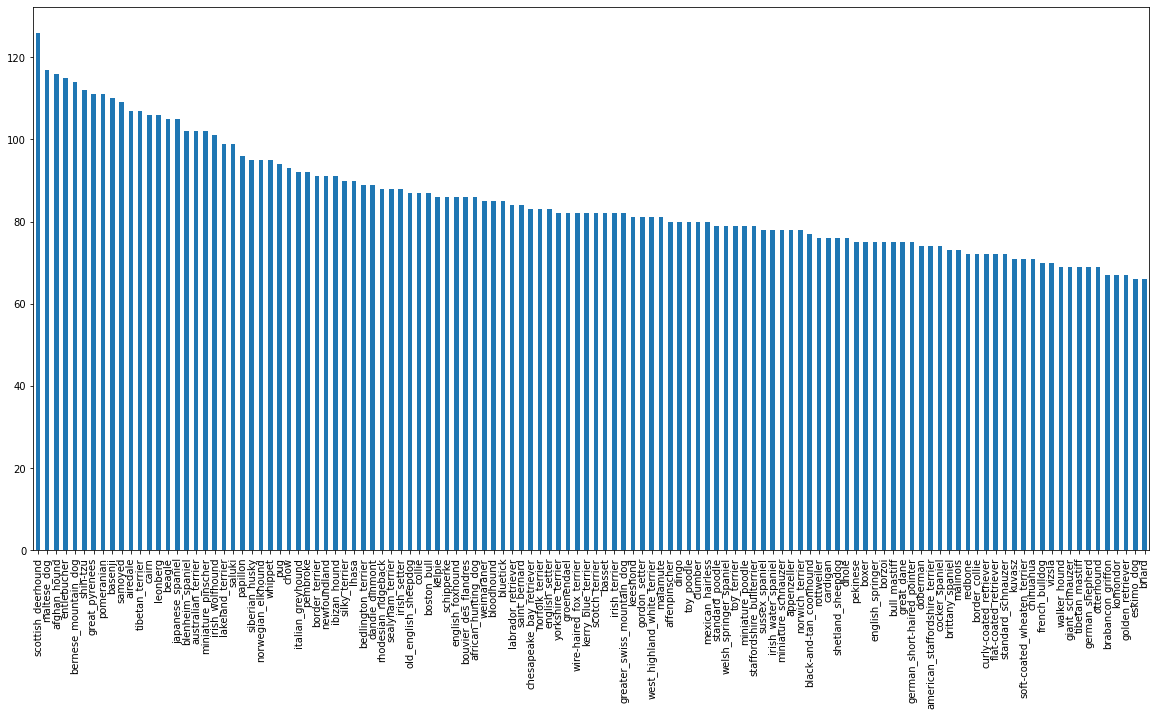

In [3]:
# No of images for each breed

labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [4]:
labels_csv['breed'].value_counts().median()

82.0

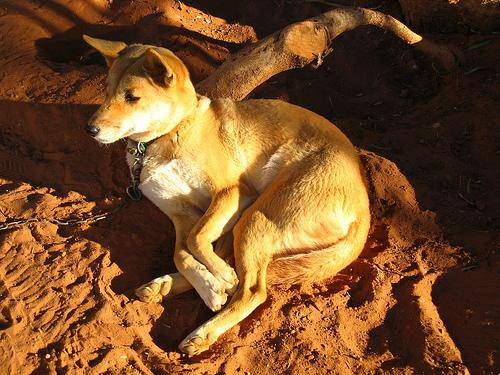

In [6]:
#Let's view an image

from IPython.display import Image

Image('/content/drive/My Drive/dogbreeddata/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Getting list of all our image file pathnames

In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
#Create pathnames from image ID's

filenames=['/drive/My Drive/dogbreeddata/train/'+fname+'.jpg' for fname in labels_csv.id]

filenames[:10]

['/drive/My Drive/dogbreeddata/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/drive/My Drive/dogbreeddata/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/drive/My Drive/dogbreeddata/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/drive/My Drive/dogbreeddata/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/drive/My Drive/dogbreeddata/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/drive/My Drive/dogbreeddata/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/drive/My Drive/dogbreeddata/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/drive/My Drive/dogbreeddata/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/drive/My Drive/dogbreeddata/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/drive/My Drive/dogbreeddata/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
#Check no of filenames matches number of actual image files

import os

if len(os.listdir('/content/drive/My Drive/dogbreeddata/train'))==len(filenames):
  print('Filenames match actual amount of files')
else:
  print('Filenames doesnt match actual amount of files')



Filenames match actual amount of files


10222